In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

from utils.utils import *

# Loading Data

In [3]:
#GitHub TidyVerse data
user_reviews = pd.read_table('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/user_reviews.tsv')
critic = pd.read_table('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/critic.tsv')
items = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/items.csv')
tidy_villagers = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/villagers.csv')

#Local data
villagers = pd.read_csv("data/acnh_villager.csv")
compatibility_villagers = pd.read_csv("data/compatibility_villagers.csv")
compatibility_matrix = pd.read_csv("data/compatibility_matrix.csv")
tier_rank = pd.read_csv("data/acnh_villager_rank_data.csv")

***
# EDA (Exploratory Data Analysis)

## Villagers database

We will use hear the data collected from the API of Nookipedia, which is more completed than the data from the TidyVerse github repository.

In [43]:
villagers.set_index("name",inplace=True)
villagers

,gender,species,personality,sign,hobby,n_appearances,tier,rank
name,,,,,,,,
Raymond,Male,Cat,Smug,Libra,Nature,1,1,1
Marshal,Male,Squirrel,Smug,Libra,Music,4,1,2
Shino,Female,Deer,Peppy,Scorpio,Education,1,1,3
Sherb,Male,Goat,Lazy,Capricorn,Nature,1,1,4
Sasha,Male,Rabbit,Lazy,Taurus,Fashion,1,1,5
...,...,...,...,...,...,...,...,...
Rocco,Male,Hippo,Cranky,Leo,Education,9,6,409
Bettina,Female,Mouse,Normal,Gemini,Education,4,6,410
Boris,Male,Pig,Cranky,Scorpio,Nature,5,6,411


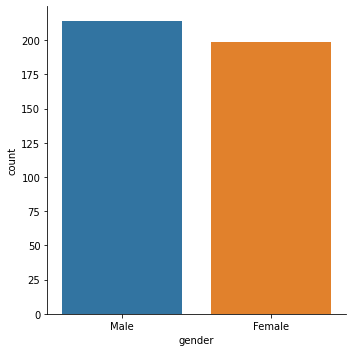

In [5]:
sns.catplot(x="gender", kind="count", data=villagers)

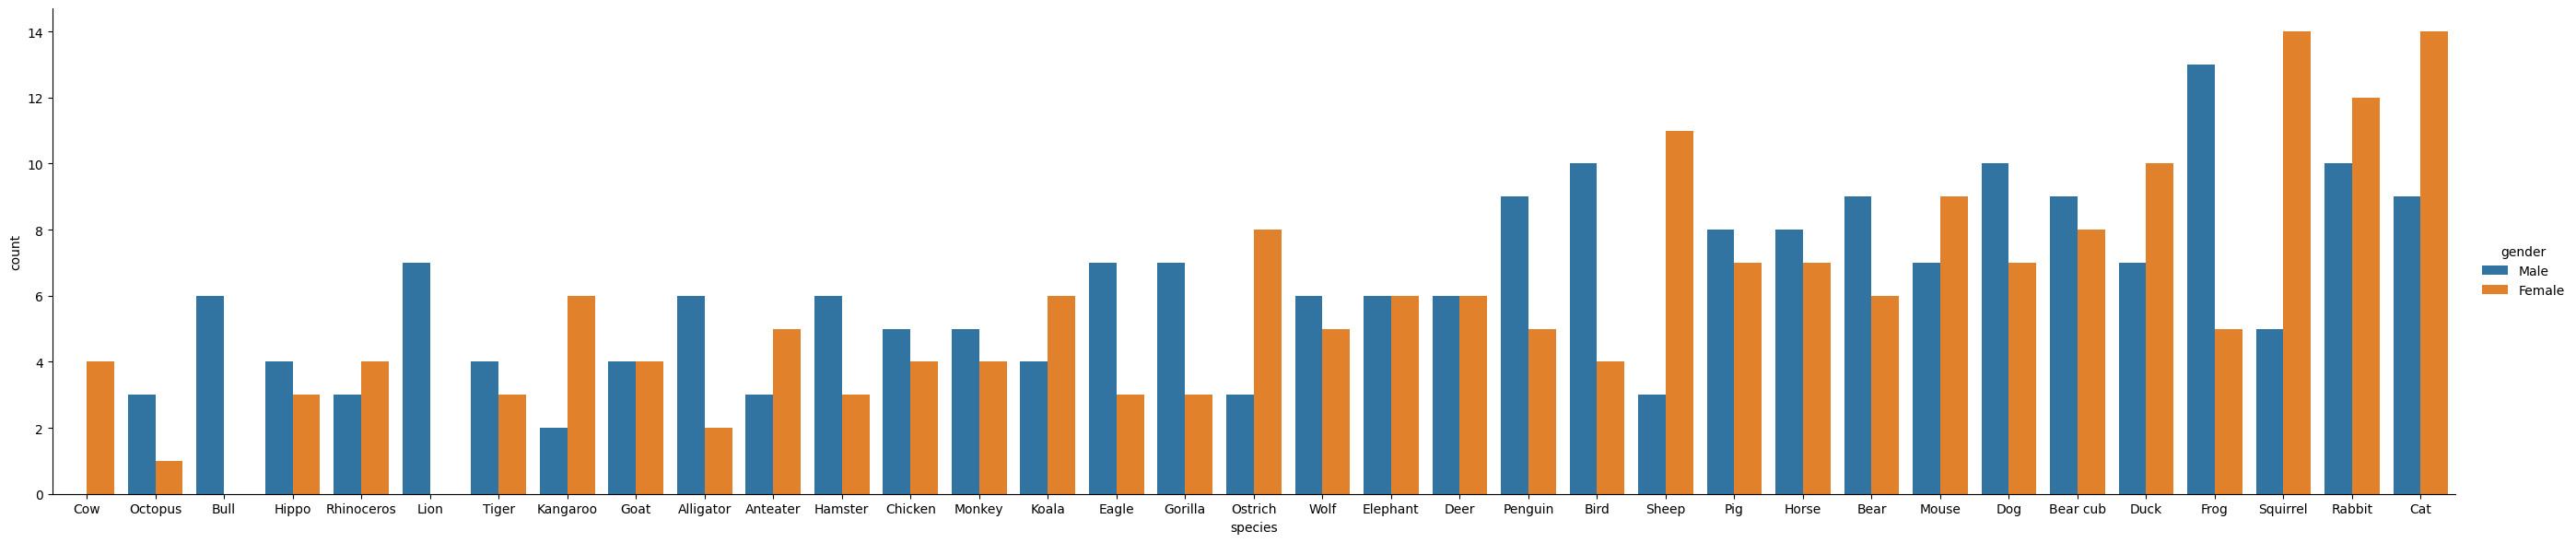

In [6]:
sns.catplot(x="species", kind="count", data=villagers, hue ="gender", order=villagers["species"].value_counts().sort_values().index, height=6, aspect=4.5)

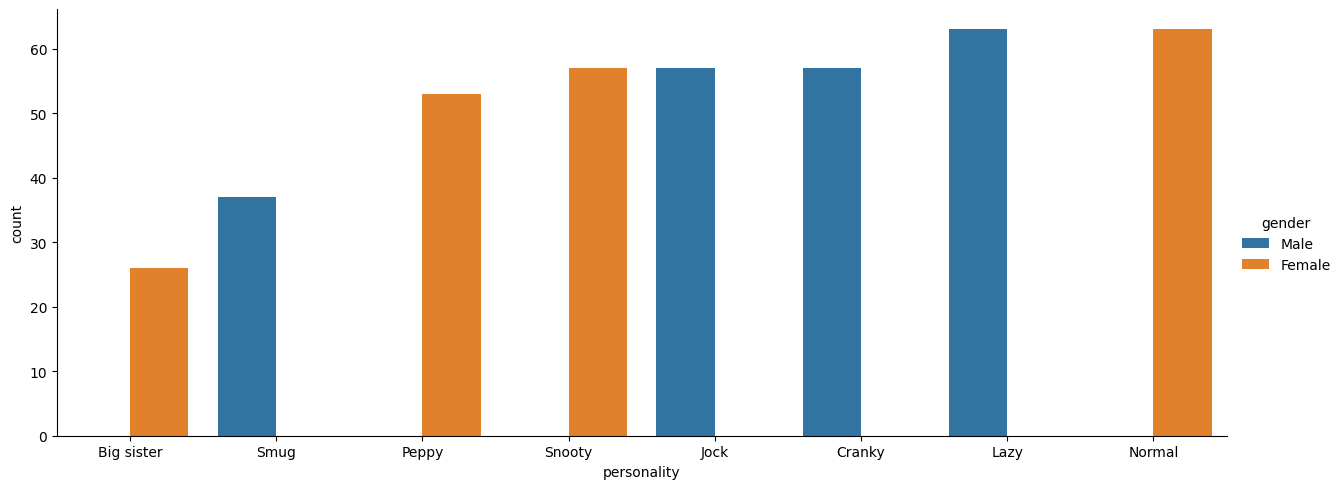

In [7]:
sns.catplot(x="personality", kind="count", hue="gender", order=villagers["personality"].value_counts().sort_values().index ,data=villagers,  aspect=2.5)

In [8]:
villagers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           413 non-null    object
 1   gender         413 non-null    object
 2   species        413 non-null    object
 3   personality    413 non-null    object
 4   sign           413 non-null    object
 5   hobby          413 non-null    object
 6   n_appearances  413 non-null    int64 
 7   tier           413 non-null    int64 
 8   rank           413 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 29.2+ KB


## Villagers popularity analysis

### Gender analysis

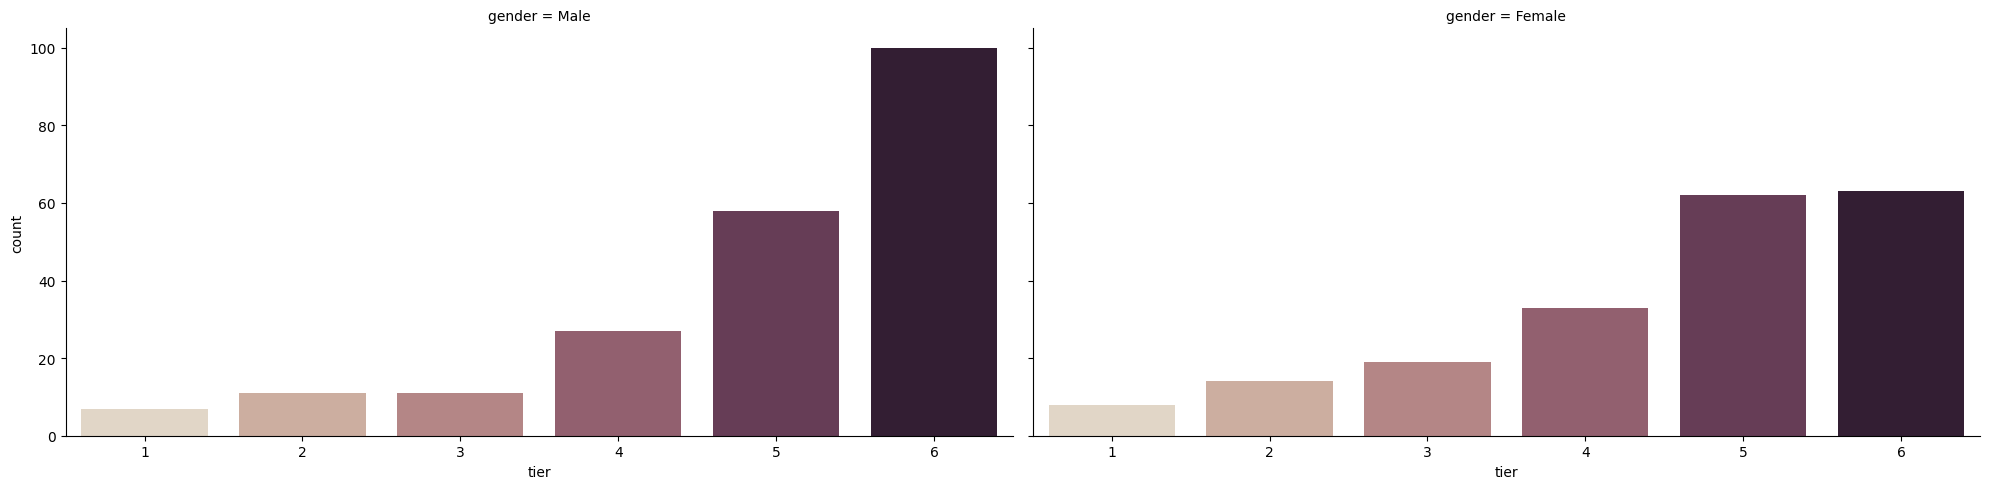

In [9]:
sns.catplot(x="tier", kind="count", palette="ch:.25", data=villagers, height=5, aspect=2, col="gender")

<AxesSubplot:xlabel='gender', ylabel='rank'>

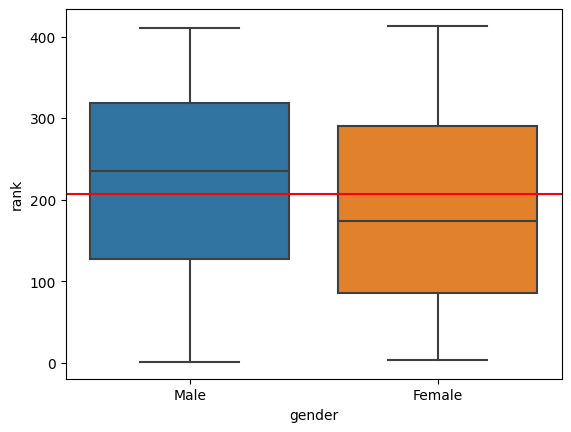

In [10]:
plt.axhline(villagers["rank"].mean(), color='r')
sns.boxplot(x="gender", y="rank", data=villagers)

### Species analysis

In [11]:
#Visualizing the popularity amongst species 
species_rank = villagers.pivot_table(values="rank", index=["species"], 
                                aggfunc={'species': np.count_nonzero,
                                            'rank': np.mean
                                        }).sort_values("rank")
species_rank.columns=["mean_rank","n"]

<AxesSubplot:xlabel='species', ylabel='mean_rank'>

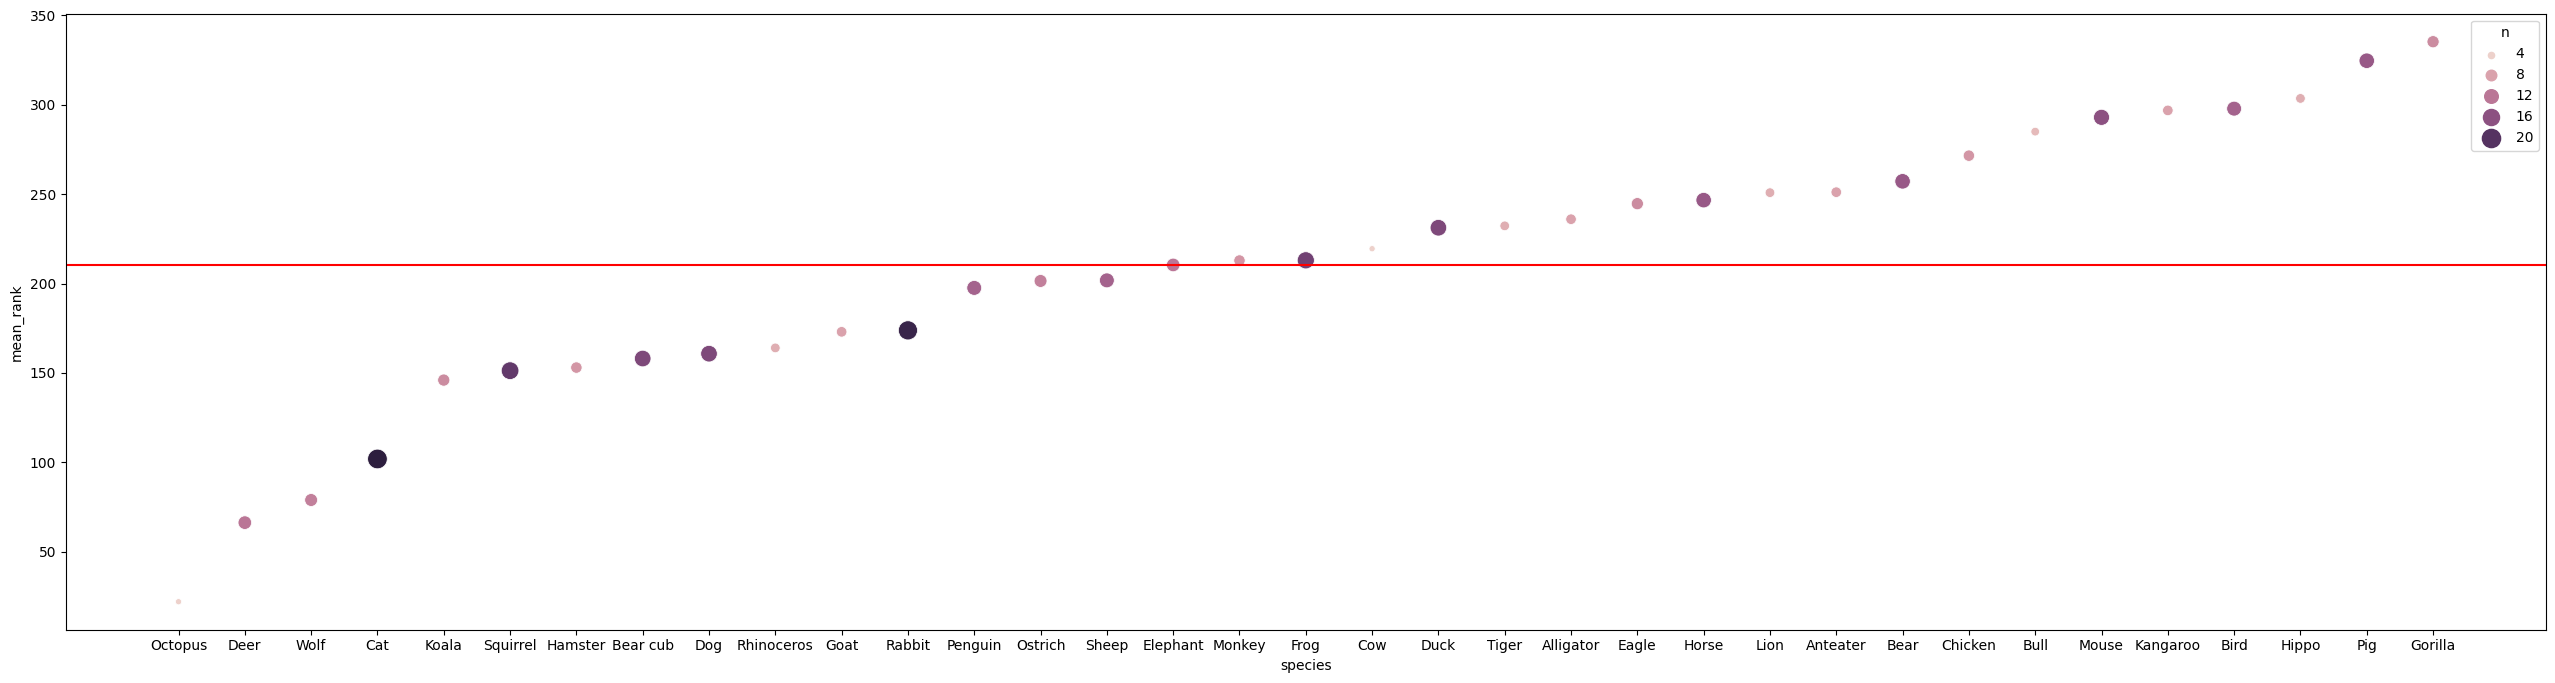

In [12]:
plt.figure(figsize=(32,8))
plt.axhline(species_rank["mean_rank"].mean(), color='r')
sns.scatterplot(x=species_rank.index, y="mean_rank", hue="n", size="n", sizes=(20, 200), data=species_rank)

### Personality analysis

In [13]:
#Constructing a dataframe counting the number of different personalities for each species
df = villagers[["personality","species"]]
species_personality = df.pivot_table(index="species", columns="personality", aggfunc=np.count_nonzero)
species_personality.fillna(0, inplace=True)
species_personality = species_personality.astype("int64")

<AxesSubplot:xlabel='species'>

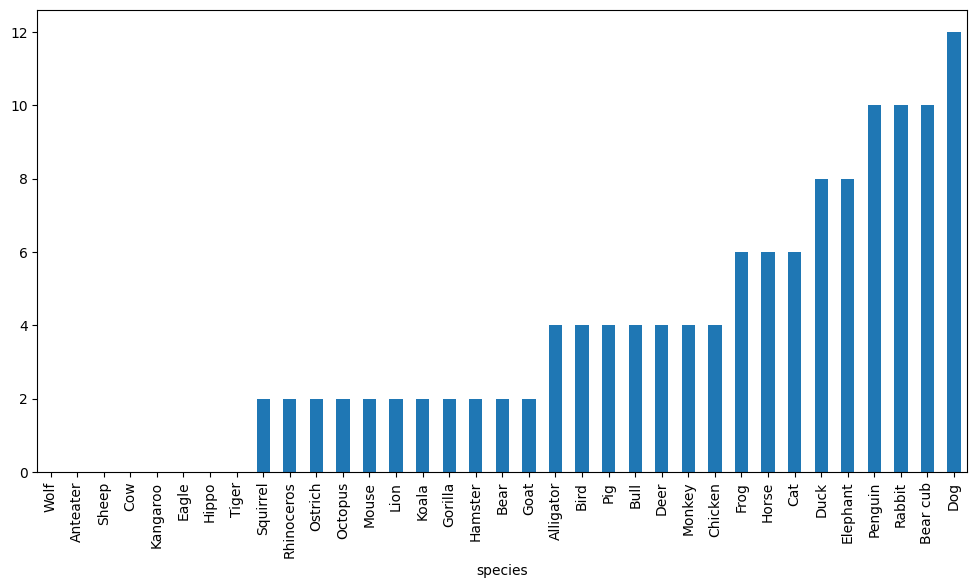

In [14]:
plt.figure(figsize=(12,6))
species_personality["Lazy"].sort_values().plot(kind="bar")

In [15]:
#Visualizing the relationship between personality and popularity 
personality_rank = villagers.pivot_table(index=["personality"], 
                                aggfunc={'personality': np.count_nonzero,
                                            'rank': np.mean
                                        }).sort_values("rank")
personality_rank.columns=["n","mean_rank"]

In [16]:
personality_rank

,n,mean_rank
personality,,
Big sister,26,159.423077
Normal,63,160.682540
Peppy,53,169.509434
Lazy,63,193.619048
Smug,37,204.135135
Jock,57,237.122807
Cranky,57,252.491228
Snooty,57,255.789474


<AxesSubplot:xlabel='personality', ylabel='mean_rank'>

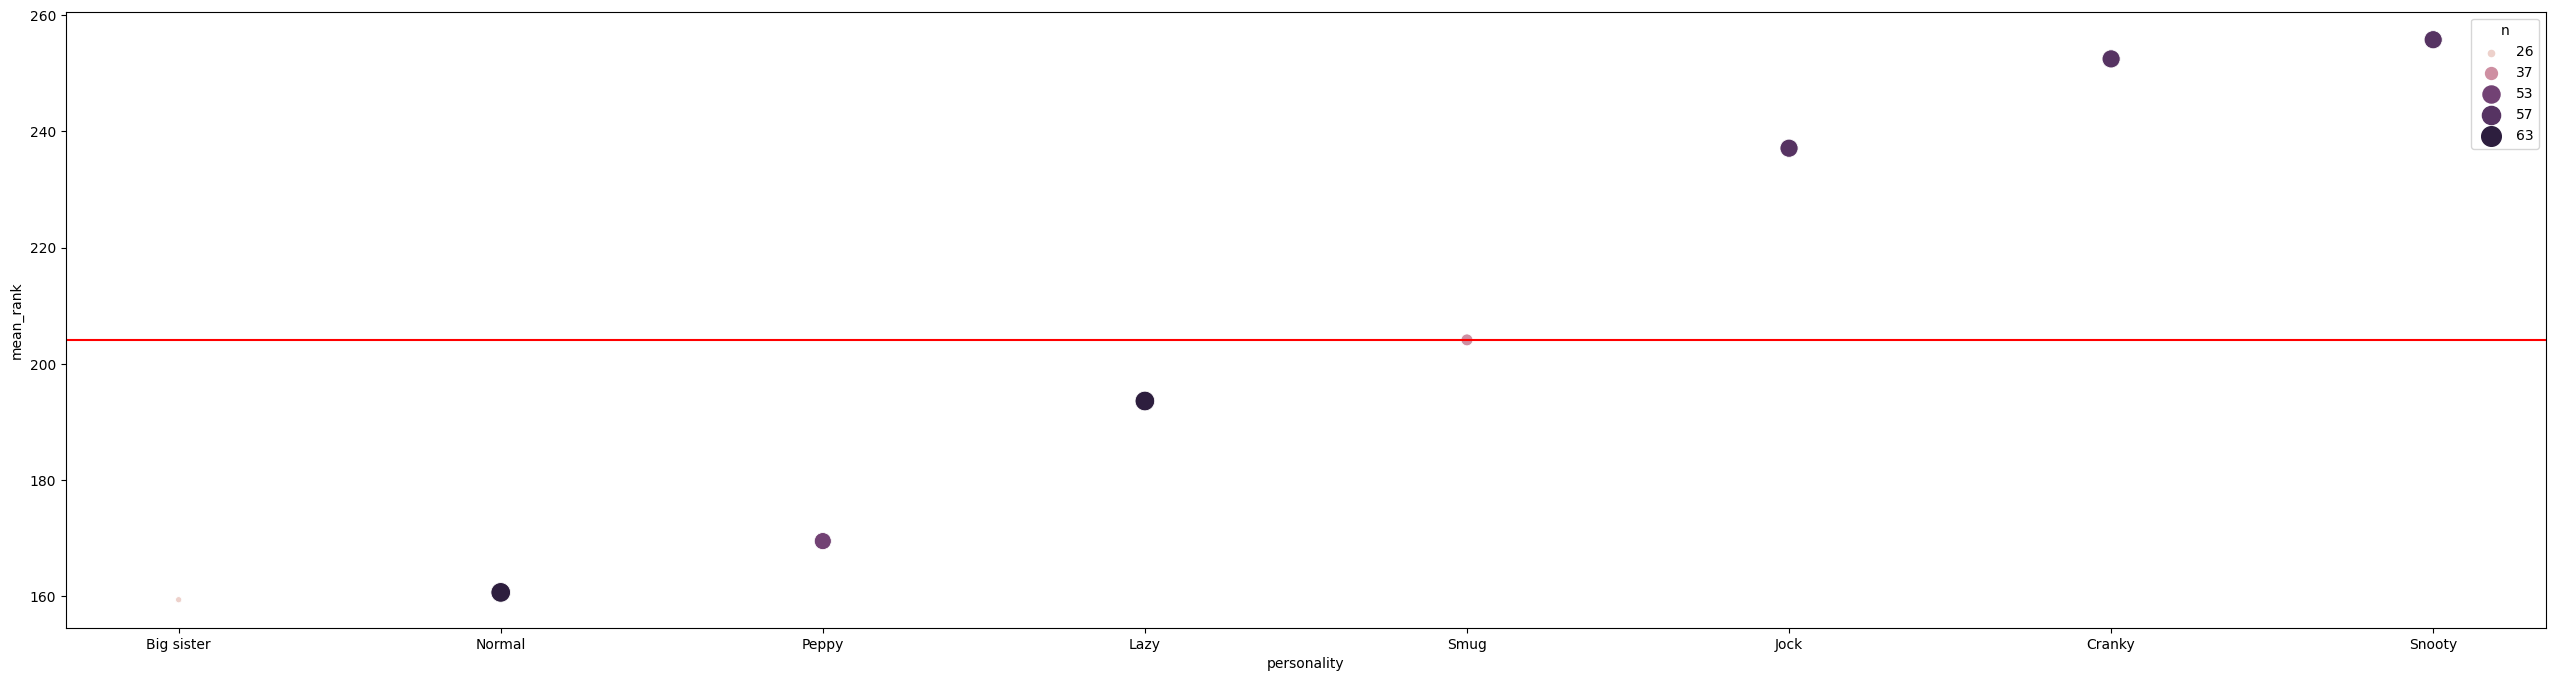

In [17]:
plt.figure(figsize=(32,8))
plt.axhline(personality_rank["mean_rank"].mean(), color='r')
sns.scatterplot(x=personality_rank.index, y="mean_rank", hue="n", size="n", sizes=(20, 200), data=personality_rank)

## Items dataset

In [18]:
items

,num_id,id,name,category,orderable,sell_value,sell_currency,buy_value,buy_currency,sources,customizable,recipe,recipe_id,games_id,id_full,image_url
0,12,3d-glasses,3D Glasses,Accessories,NaN,122.0,bells,490.0,bells,NaN,NaN,NaN,NaN,nh,item-3d-glasses,https://villagerdb.com/images/items/full/3d-gl...
1,14,a-tee,A Tee,Tops,NaN,140.0,bells,560.0,bells,NaN,NaN,NaN,NaN,nh,item-a-tee,https://villagerdb.com/images/items/full/a-tee...
2,17,abstract-wall,Abstract Wall,Wallpaper,True,390.0,bells,1560.0,bells,Nook's Cranny,NaN,NaN,NaN,nh,NaN,NaN
3,19,academy-uniform,Academy Uniform,Dresses,NaN,520.0,bells,2080.0,bells,NaN,NaN,NaN,NaN,nh,item-academy-uniform,https://villagerdb.com/images/items/full/acade...
4,20,acanthostega,Acanthostega,Fossils,False,2000.0,bells,NaN,NaN,Underground (dig spot),NaN,NaN,NaN,nh,item-acanthostega,https://villagerdb.com/images/items/thumb/acan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,7425,zigzag-shirt,Zigzag Shirt,Tops,True,240.0,bells,960.0,bells,Nook Shopping,NaN,NaN,NaN,nh,item-zigzag-shirt,https://villagerdb.com/images/items/full/zigza...
4561,7428,zippers-poster,Zipper's Poster,Photos,NaN,250.0,bells,1000.0,bells,NaN,NaN,NaN,NaN,nh,NaN,NaN
4562,7441,zori,Zori,Shoes,NaN,1075.0,bells,4300.0,bells,NaN,NaN,NaN,NaN,nh,item-zori,https://villagerdb.com/images/items/full/zori....
4563,7442,zuckers-photo,Zucker's Photo,Photos,NaN,10.0,bells,40.0,bells,NaN,NaN,NaN,NaN,nh,NaN,NaN


In [19]:
#Droping useless features
items.drop(columns=["id", "num_id", "id_full","image_url"], inplace=True)

In [20]:
list(items["category"].value_counts().sort_values(ascending=False).index)

['Furniture',
 'Photos',
 'Flooring',
 'Tops',
 'Wallpaper',
 'Dresses',
 'Hats',
 'Bottoms',
 'Accessories',
 'Flowers',
 'Fish',
 'Music',
 'Shoes',
 'Usables',
 'Bugs',
 'Fossils',
 'Tools',
 'Umbrellas',
 'Socks',
 'Fruit',
 'Seashells']

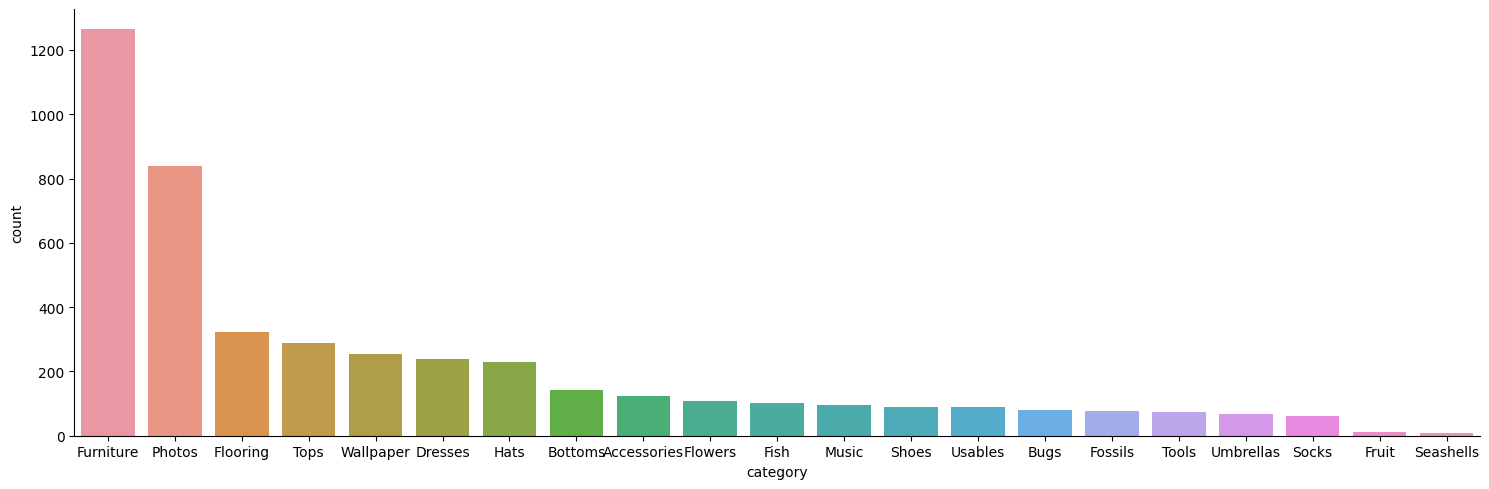

In [21]:
sns.catplot(kind="count", x="category", data=items, order=list(items["category"].value_counts().sort_values(ascending=False).index),
            orient="h", aspect=3.0)

In [22]:
#Check for missing values and some overall info about the data set
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4565 entries, 0 to 4564
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4565 non-null   object 
 1   category       4565 non-null   object 
 2   orderable      1790 non-null   object 
 3   sell_value     4529 non-null   float64
 4   sell_currency  4529 non-null   object 
 5   buy_value      3551 non-null   float64
 6   buy_currency   3551 non-null   object 
 7   sources        902 non-null    object 
 8   customizable   575 non-null    object 
 9   recipe         588 non-null    float64
 10  recipe_id      588 non-null    object 
 11  games_id       4565 non-null   object 
dtypes: float64(3), object(9)
memory usage: 428.1+ KB


In [23]:
#Summary of how many missing values are contained within the dataframe
items.isna().sum()

name                0
category            0
orderable        2775
sell_value         36
sell_currency      36
buy_value        1014
buy_currency     1014
sources          3663
customizable     3990
recipe           3977
recipe_id        3977
games_id            0
dtype: int64

<AxesSubplot:>

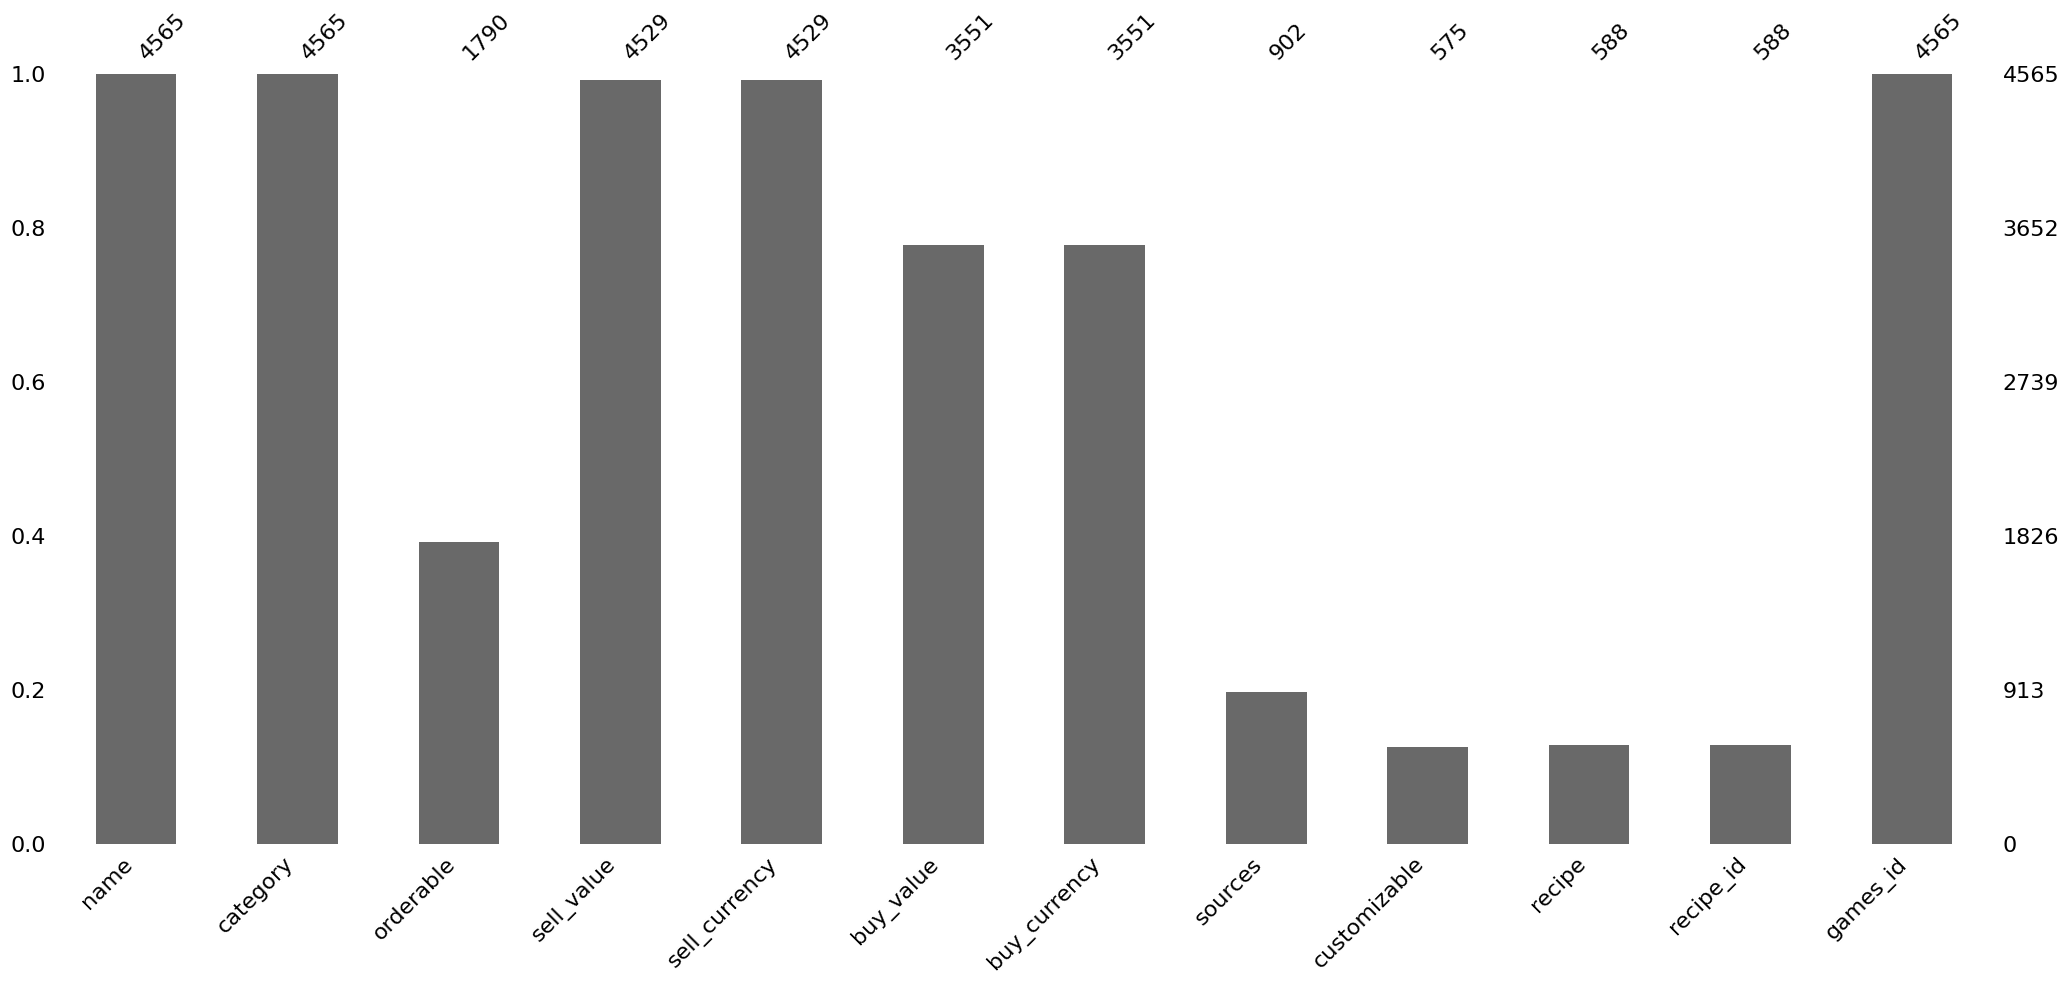

In [24]:
#Visualizing missing values
msno.bar(items)

<AxesSubplot:>

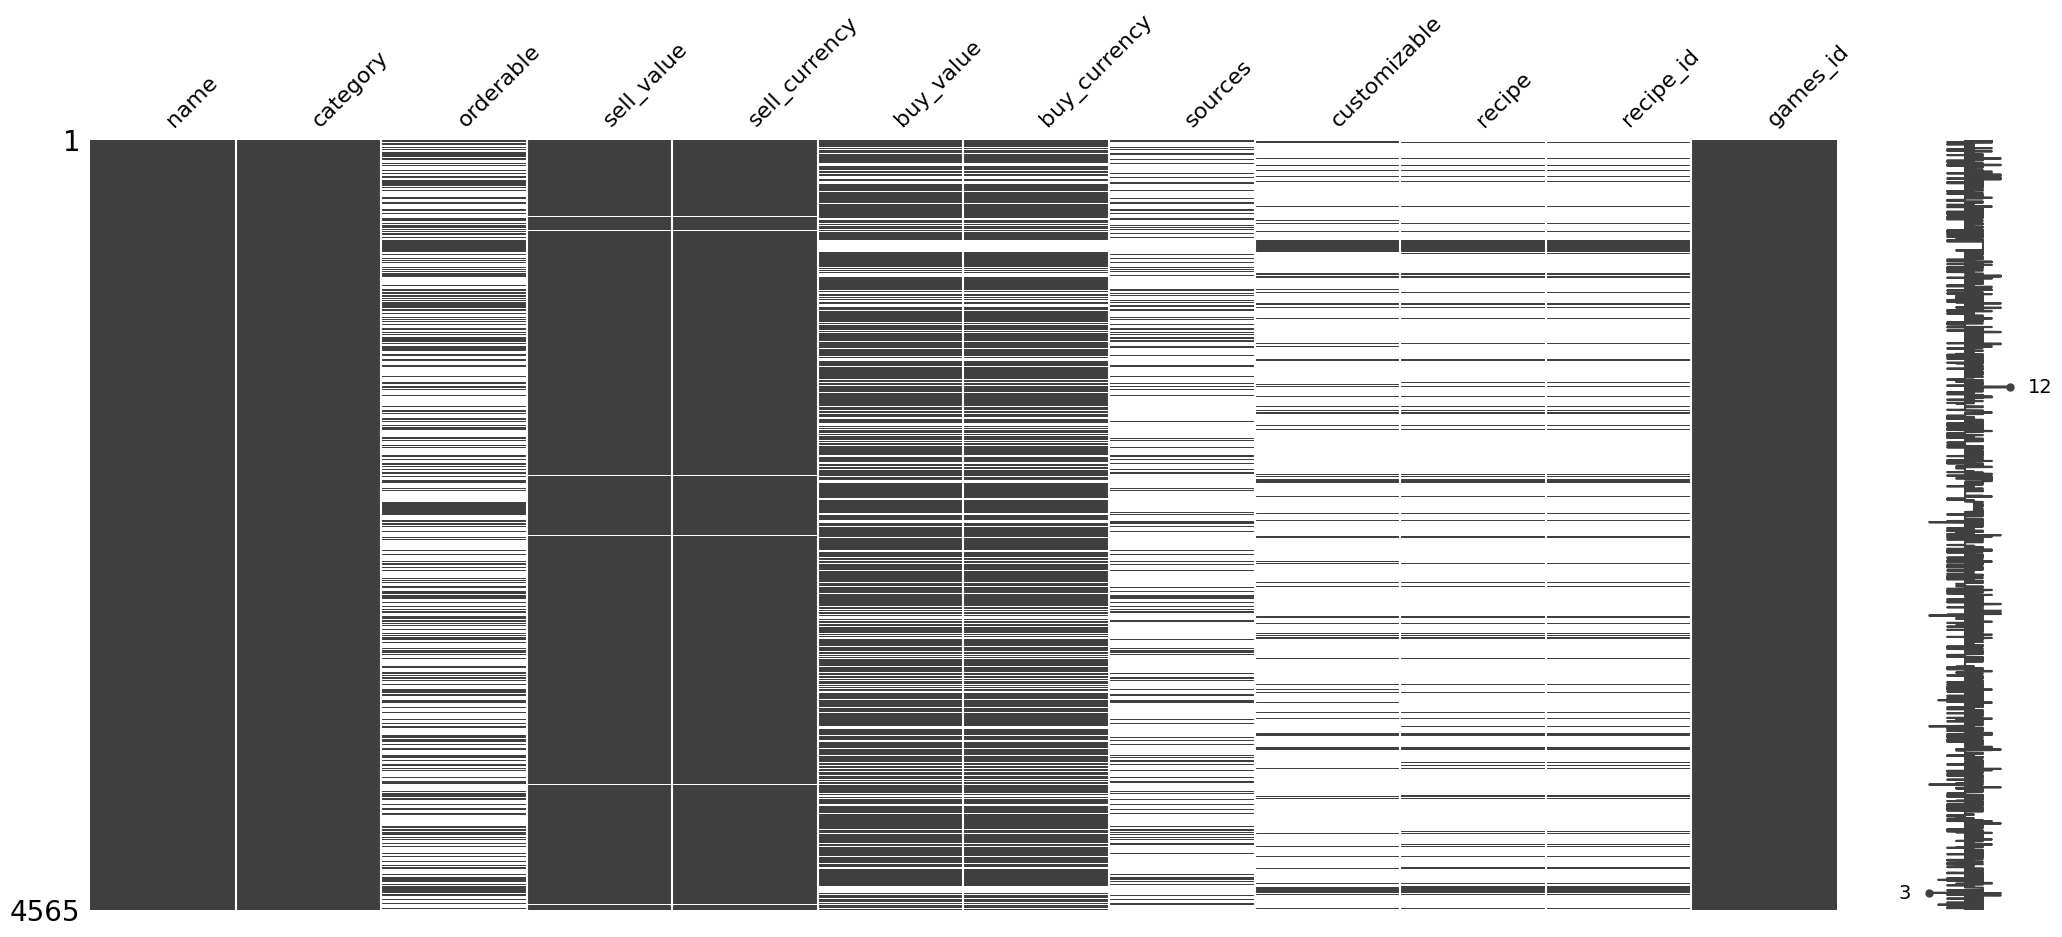

In [25]:
#Visualizing where the missing values are located 
msno.matrix(items)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sell_value', ylabel='Density'>

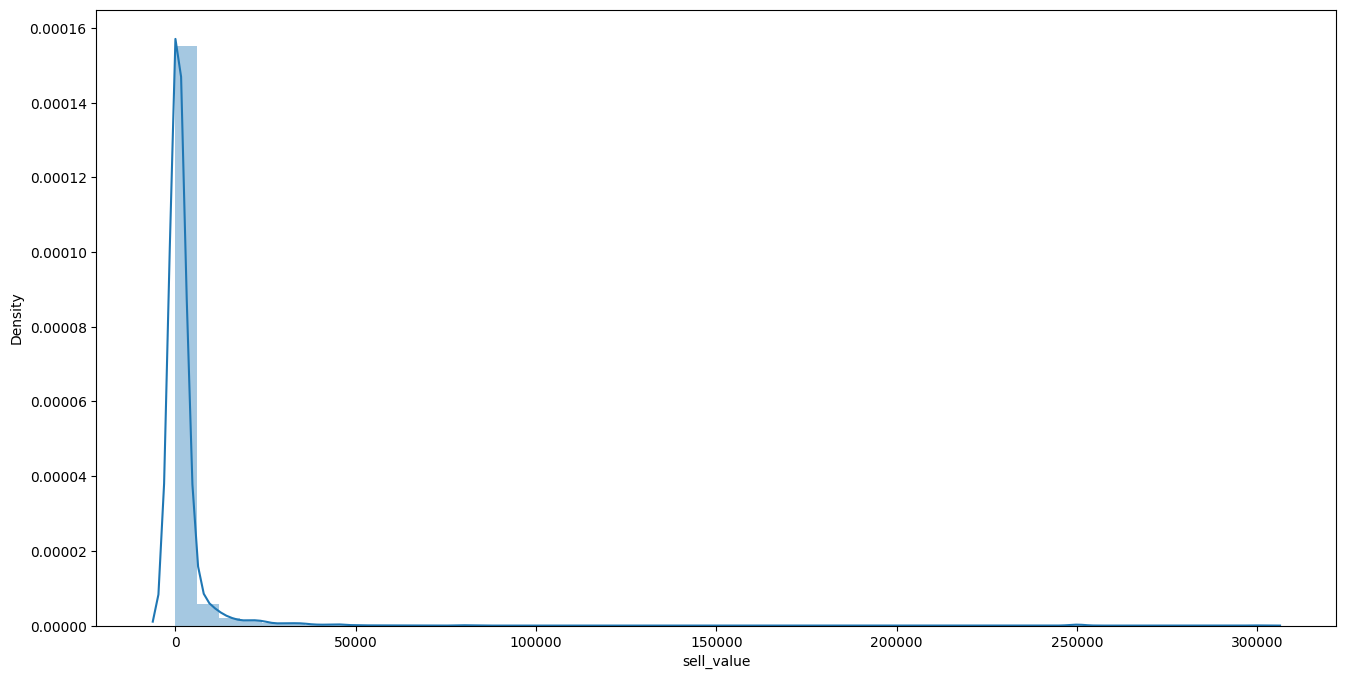

In [26]:
#Trying to vizualise the sell_value distribution, however due to some high sell_values the distribution is hard to determine
plt.figure(figsize=(16,8))
sns.distplot(a=items["sell_value"])

In [27]:
items["sell_value"].describe()

count      4529.000000
mean       2261.378229
std       11313.225932
min           5.000000
25%         240.000000
50%         390.000000
75%        1000.000000
max      300000.000000
Name: sell_value, dtype: float64

<AxesSubplot:xlabel='sell_value'>

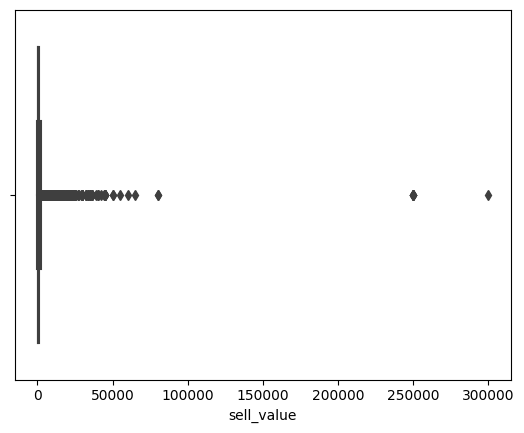

In [28]:
sns.boxplot(x=items["sell_value"])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sell_value', ylabel='Density'>

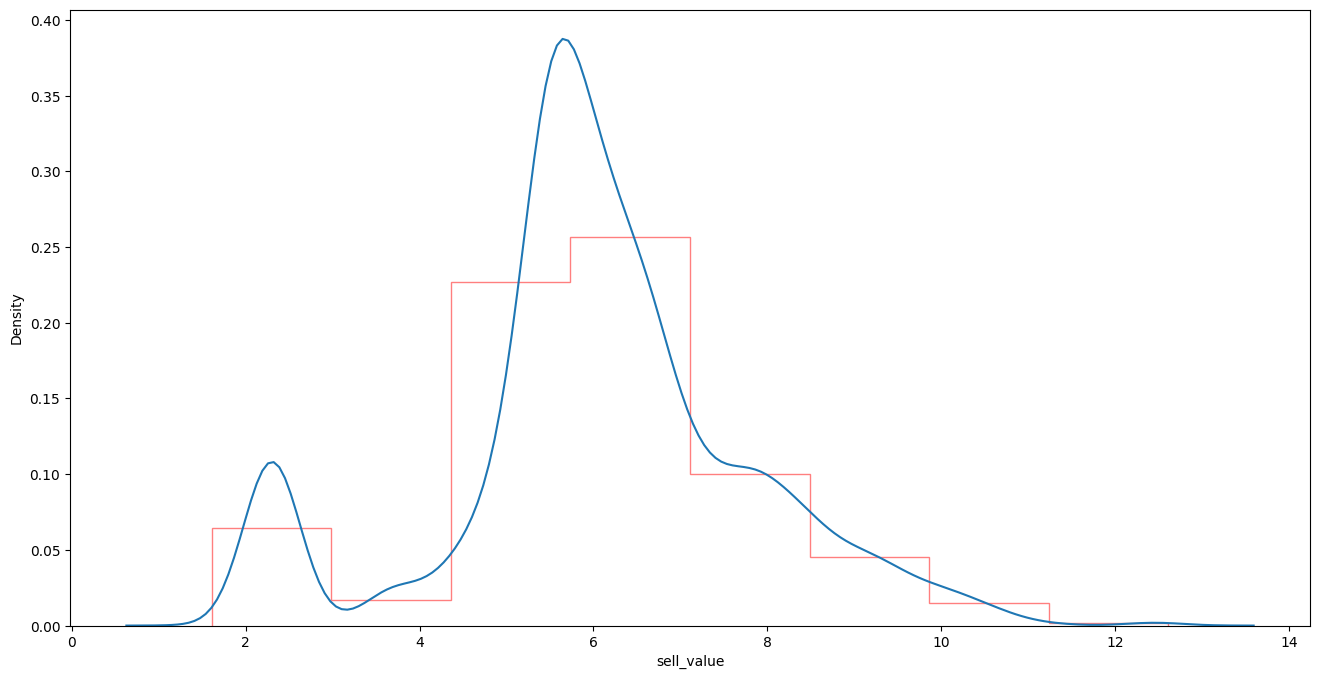

In [29]:
#To overcome the extreme values impact on the distribution vizualization, let's transform our data with the log function
plt.figure(figsize=(16,8))
sns.distplot(a=np.log(items["sell_value"]), bins=8,
            hist_kws={"histtype": "step", "linewidth": 1,
                    "alpha": 0.5, "color": "r"})

<AxesSubplot:xlabel='sell_value', ylabel='buy_value'>

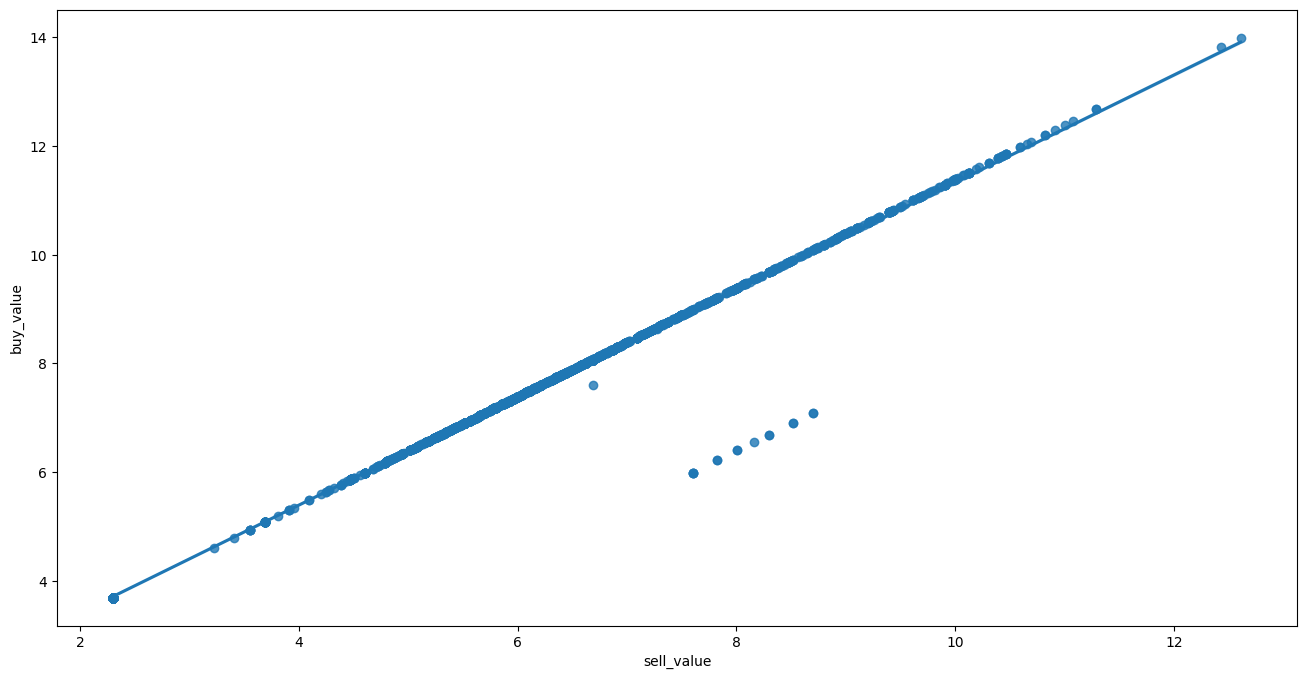

In [30]:
#The relationship between the sell and the buy value is a nearly perfect linear relationship
plt.figure(figsize=(16,8))
sns.regplot(x=np.log(items["sell_value"]), y=np.log(items["buy_value"]))

***
# Clustering

The difficulty lay in the various categorical features contained in our dataset. One way to deal with those features are to use an encoder.

In [40]:
villagers

,name,gender,species,personality,sign,hobby,n_appearances,tier,rank
0,Raymond,Male,Cat,Smug,Libra,Nature,1,1,1
1,Marshal,Male,Squirrel,Smug,Libra,Music,4,1,2
2,Shino,Female,Deer,Peppy,Scorpio,Education,1,1,3
3,Sherb,Male,Goat,Lazy,Capricorn,Nature,1,1,4
4,Sasha,Male,Rabbit,Lazy,Taurus,Fashion,1,1,5
...,...,...,...,...,...,...,...,...,...
408,Rocco,Male,Hippo,Cranky,Leo,Education,9,6,409
409,Bettina,Female,Mouse,Normal,Gemini,Education,4,6,410
410,Boris,Male,Pig,Cranky,Scorpio,Nature,5,6,411
411,Bitty,Female,Hippo,Snooty,Libra,Education,5,6,412


In [48]:
villagers

,gender,species,personality,sign,hobby,n_appearances,tier,rank
name,,,,,,,,
Raymond,Male,Cat,Smug,Libra,Nature,1,1,1
Marshal,Male,Squirrel,Smug,Libra,Music,4,1,2
Shino,Female,Deer,Peppy,Scorpio,Education,1,1,3
Sherb,Male,Goat,Lazy,Capricorn,Nature,1,1,4
Sasha,Male,Rabbit,Lazy,Taurus,Fashion,1,1,5
...,...,...,...,...,...,...,...,...
Rocco,Male,Hippo,Cranky,Leo,Education,9,6,409
Bettina,Female,Mouse,Normal,Gemini,Education,4,6,410
Boris,Male,Pig,Cranky,Scorpio,Nature,5,6,411


In [72]:
X = villagers.drop(["tier", "rank", "hobby", "n_appearances"], axis=1)

We can use an **ordinal** encoder, which will wrongly assume an order relationship, or a **one hot** encoder, which is computationnally expensive.

In [45]:
ordinal = OrdinalEncoder()
X_ordinal = ordinal.fit_transform(X)

In [73]:
onehot = OneHotEncoder(sparse=False)
X_onehot = onehot.fit_transform(X)

Now we can apply PCA on our dataset:

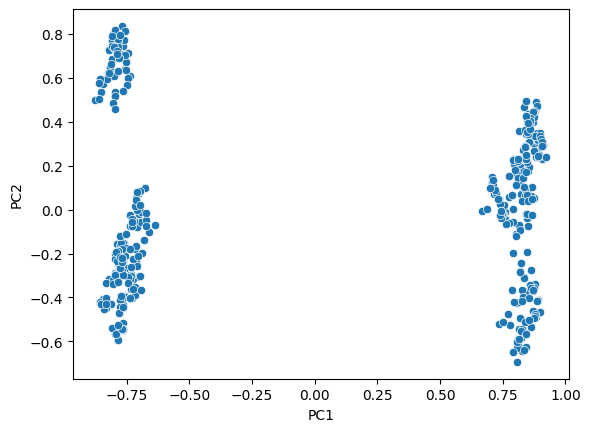

In [74]:
_, one_hot_pca = scatterplot_pca(data=pd.DataFrame(X_onehot))
X_onehot_pca = one_hot_pca.transform(X_onehot)

We can then perform a clustering task:

In [70]:
cls = KMeans(n_clusters=6, init='k-means++')
cls.fit(X_onehot_pca)

labels = pd.Series(cls.labels_, name="K-means")

<AxesSubplot:>

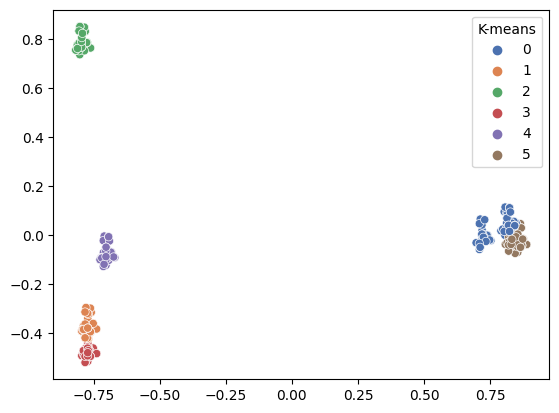

In [71]:
sns.scatterplot(x=X_onehot_pca[:,0], y=X_onehot_pca[:,1], hue=labels, palette="deep")